In [1]:
using LinearAlgebra
using Plots
using Dierckx #オイラー残差のため
using DelimitedFiles
using LaTeXStrings

In [2]:
include("Utils.jl")
include("Models.jl")

Models

In [3]:
function ddp(m::Models)
    """
    状態変数と操作変数を離散化して動的計画法(discretized DP)を解く.
    
    # Arguments
    
    # Returns 
    
    """
    
    count = 1 #価値関数の図示の際に利用
     
    #STEP 1(b): 価値関数・政策関数の初期値を設定
    
    vfcn = zeros(m.nk)
    pfcn = similar(vfcn)
    Tvfcn = similar(vfcn)
    Tpfcn = similar(vfcn)
    val_tmp = zeros(m.nk, 4)
    dif = zeros(2, 1000)
    
    #STEP 3: 効用関数の組み合わせ

    # 効用関数の初期値 (消費が0以下になる組み合わせにはペナルティ)
    util = -10000.0*ones(m.nk, m.nk)

    # MATLAB版と効用行列の構成が異なることに注意
    wealth = m.kgrid.^m.α + (1.0-m.δ)*m.kgrid
    # 消費が正値になる(k,k')の組み合わせについて効用を計算
    @inbounds for i in 1 : m.nk # あらゆる状態変数kについて
        @inbounds for j in 1 : m.nk # あらゆる操作変数k'について
            cons = wealth[i] - m.kgrid[j]
            if cons > 0.0
               util[i,j] = Utils.CRRA(cons, m.γ)
            end
        end
    end

    # STEP 4: 価値関数を繰り返し計算
    #　最大値を求めるコーディングがMATLAB版とは違うことに注意
    for iter in 1:m.maxiter
        
        @inbounds for i in 1:m.nk # あらゆる状態変数kについて
            vmin = -10000.0
            @inbounds for j in 1:m.nk # あらゆる操作変数k'について
                temp = util[i,j] + m.β*vfcn[j]
                if temp > vmin
                    Tvfcn[i] = temp 
                    Tpfcn[i] = m.kgrid[j]
                    vmin = temp
                #else
                   #break #凹性の利用
                end
            end
        end
        
        # 繰り返し計算誤差を確認
        dif1 = maximum(abs.((Tvfcn-vfcn)./vfcn))
        dif2 = maximum(abs.((Tpfcn-pfcn)./pfcn))
        
        # 価値関数・政策関数をアップデート
        vfcn = copy(Tvfcn)
        pfcn = copy(Tpfcn)
        
        # 収束途中の繰り返し計算誤差を保存
        #途中経過を図示する目的なので、通常は不要(むしろ遅くなるので消すべき)
        dif[1, iter] = dif1
        dif[2, iter] = dif2 

        # 同じく価値関数の収束を図示する目的で保存(本来は不要)
        if iter==1 || iter==3 || iter==5
           val_tmp[:, count] = vfcn
           count = count + 1
        end
        
        if dif1 < m.tol
            val_tmp[:, end] = vfcn
            break  
        end
        
        if iter == m.maxiter
            println("The model does not converge")
        end
    end  
    return vfcn, pfcn, dif, val_tmp
end

ddp (generic function with 1 method)

In [4]:
m = Models(nk = 10001, kmax = 0.5)

Models{Int64,Float64,Array{Float64,1}}(0.96, 1.0, 0.4, 1.0, 10, 10001, [0.05, 0.050045, 0.05009, 0.050135, 0.05018, 0.050225, 0.05027, 0.050315, 0.05036, 0.050405  …  0.499595, 0.49964, 0.499685, 0.49973, 0.499775, 0.49982, 0.499865, 0.49991, 0.499955, 0.5], 1000, 1.0e-5)

In [5]:
vfcn, pfcn, dif, val_tmp = ddp(m)

([-28.9677, -28.9671, -28.9665, -28.9659, -28.9653, -28.9648, -28.9642, -28.9636, -28.963, -28.9624  …  -27.473, -27.473, -27.4729, -27.4728, -27.4728, -27.4727, -27.4727, -27.4726, -27.4726, -27.4725], [0.115835, 0.11588, 0.115925, 0.11597, 0.116015, 0.11606, 0.116105, 0.11615, 0.116195, 0.11624  …  0.29093, 0.29093, 0.290975, 0.290975, 0.290975, 0.290975, 0.290975, 0.29102, 0.29102, 0.29102], [Inf 2.74425 … 0.0 0.0; Inf 3.501 … 0.0 0.0], [-1.37948 -3.72357 -5.73462 -28.9677; -1.37905 -3.72302 -5.73404 -28.9671; … ; -0.34555 -2.29675 -4.2496 -27.4726; -0.345511 -2.29669 -4.24954 -27.4725])

In [6]:
@time ddp(m);

184.196114 seconds (2.50 k allocations: 1.584 GiB, 0.15% gc time)


In [7]:
#解析解
AA = (1.0-m.β)^(-1) * (log(1.0-m.α*m.β) + ((m.α*m.β)/(1.0-m.α*m.β))*log(m.α*m.β))
BB = m.α/(1.0-m.α*m.β)
v_true = AA .+ BB*log.(m.kgrid)
p_true = m.α*m.β*(m.kgrid.^m.α);

In [8]:
# オイラー方程式から誤差を測定
nkk = 21
kgrid2 = collect(LinRange(m.kgrid[1], m.kgrid[end], nkk))
pfcn0 = zeros(nkk)

for i in 1:nkk
    pfcn0[i] = pfcn[500*(i-1)+1]
end

cons = kgrid2.^m.α + (1.0 - m.δ)*kgrid2 - pfcn0

LHS = Utils.mu_CRRA.(cons, m.γ)
kp = pfcn0
spl = Spline1D(kgrid2, pfcn0, k = 1, bc = "extrapolate")
kpp = spl(kp)
cons = kp.^m.α + (1 - m.δ) * kp - kpp
rent = m.α*kp.^(m.α - 1) .- m.δ
RHS = m.β*(1 .+ rent) .* Utils.mu_CRRA.(cons, m.γ)
err = RHS./LHS .- 1.0;

In [9]:
open("err_ddp.txt", "w") do io
           writedlm(io, err)
       end

# プロット

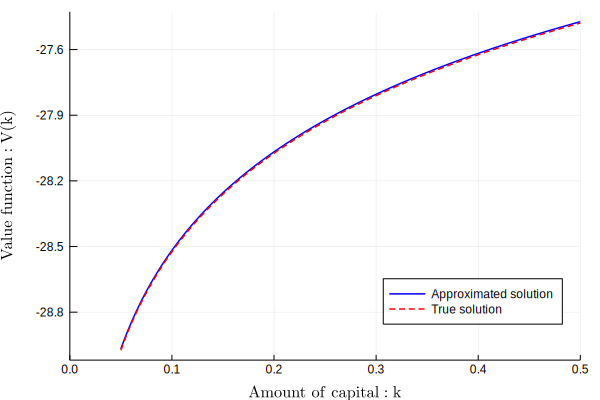

In [10]:
plot(m.kgrid, vfcn, 
     label ="Approximated solution", 
     line = (1.5, :solid), color ="blue",
     legend=:bottomright)
plot!(m.kgrid, v_true, 
      label = "True solution",
      line = (1.5, :dash), color ="red")

xlabel!(L"\mathrm{Amount\ of\ capital :  k }")
ylabel!(L"\mathrm{Value\  function  :  V(k)} ")
xlims!(0, m.kgrid[end])
#savefig("Fig3_dndp1.pdf")

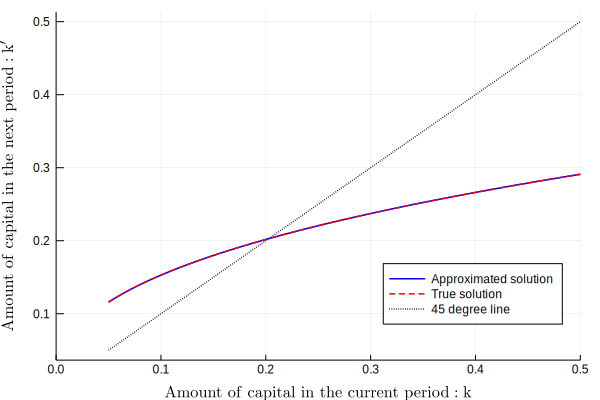

In [11]:
plot(m.kgrid, pfcn, 
     label ="Approximated solution", 
     line = (1.5, :solid), color ="blue",
     legend=:bottomright)
plot!(m.kgrid, p_true, 
      label = "True solution",
      line = (1.5, :dash), color ="red")

plot!(m.kgrid, m.kgrid, 
      label = "45 degree line",
      line = (1.5, :dot), color="black")
xlabel!(L"\mathrm{Amount\ of\ capital\ in\ the\ current\ period :  k }")
ylabel!(L"\mathrm{Amount\ of\ capital\ in\ the\ next\ period :  k'}")
xlims!(0, m.kgrid[end])
#savefig("Fig3_dndp2.pdf")

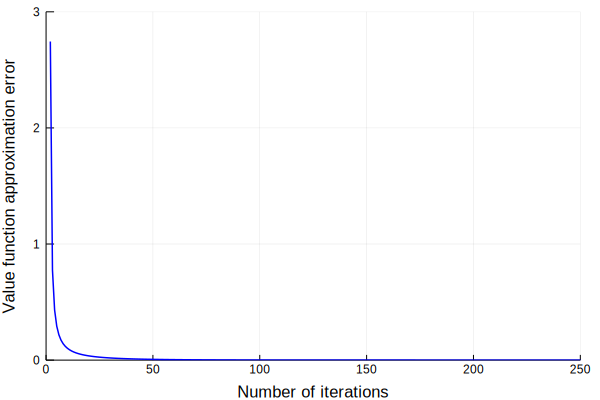

In [12]:
x = 1:m.maxiter
plot(x, dif[1,:], label = "", line = 1.5, color="blue")
xlims!(0,250)
ylims!(0, 3.0)
ylabel!("Value function approximation error")
xlabel!("Number of iterations")
#savefig("Fig3_dndp3.pdf")

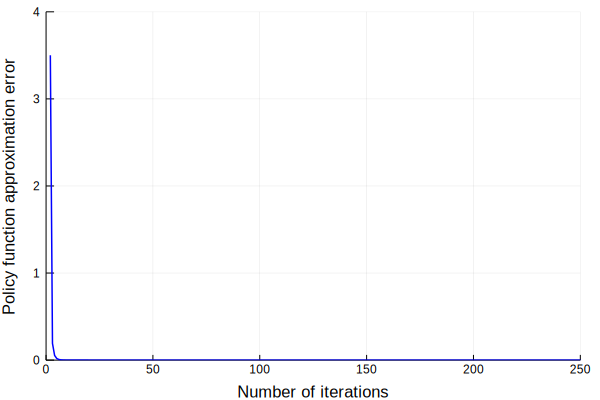

In [13]:
x = 1:m.maxiter
plot(x, dif[2,:], label = "", line = 1.5, color="blue")
xlims!(0,250)
ylims!(0, 4.0)
ylabel!("Policy function approximation error")
xlabel!("Number of iterations")
#savefig("Fig3_dndp4.pdf")

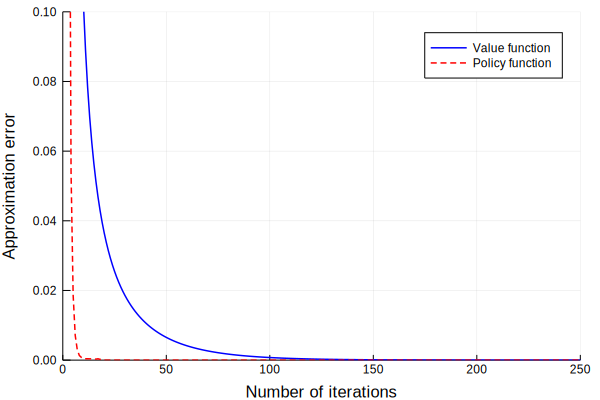

In [14]:
styles = filter((s->begin
                s in Plots.supported_styles()
            end), [:solid, :dash])
styles = reshape(styles, 1, length(styles))

x = 1:m.maxiter
plot(x, dif', line = (1.5, styles), color =["blue" "red"],
     label =["Value function" "Policy function"])
xlims!(0,250)
ylims!(0, 0.1)
ylabel!("Approximation error")
xlabel!("Number of iterations")
#savefig("Fig3_dndp5.pdf")

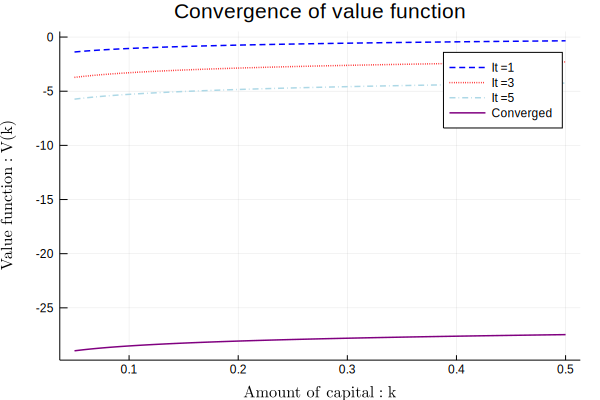

In [15]:
styles = filter((s->begin
                s in Plots.supported_styles()
            end), [:dash, :dot, :dashdot, :solid])
styles = reshape(styles, 1, length(styles))

plot(m.kgrid,val_tmp, line=(1.5, styles),
     label = ["It =1" "It =3" "It =5" "Converged"],
     color = ["blue" "red" "lightblue" "purple"])
xlabel!(L"\mathrm{Amount\ of\ capital :  k }")
ylabel!(L"\mathrm{Value\  function  :  V(k)} ")
title!("Convergence of value function")
#savefig("Fig3_dndp6.pdf")